<a href="https://colab.research.google.com/github/cdario79/FiltroFakeNews/blob/main/Filtro_per_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## IMPORTAZIONE LIBRERIE UTILIZZATE

In [2]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.5 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries for data manipulation and analysis
import re  # Regular expressions for text processing
import os  # Operating system functionalities
import requests  # HTTP requests to access web content
import unicodedata  # Import the unicodedata module to work with Unicode character properties and normalization.
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# Importing libraries for data visualization
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
from wordcloud import WordCloud  # Word cloud visualization

# Importing libraries for natural language processing (NLP)
import nltk  # Natural language processing toolkit
from nltk.corpus import stopwords  # List of common stopwords
from nltk.util import ngrams  # Generating n-grams
from nltk import word_tokenize, pos_tag, ne_chunk  # Tokenization, part-of-speech tagging, named entity recognition
from collections import Counter  # Counter for counting occurrences
nltk.download('stopwords')  # Downloading stopwords corpus
nltk.download('punkt')  # Downloading Punkt tokenizer models
nltk.download('averaged_perceptron_tagger')  # Downloading averaged perceptron tagger
nltk.download('maxent_ne_chunker')  # Downloading maxent named entity chunker
nltk.download('words')  # Downloading words corpus used by the named entity chunker

# Importing libraries for machine learning
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer for text data
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Metrics for model evaluation

# Importing libraries for topic modeling
from gensim import corpora, models  # Libraries for topic modeling
from gensim.models import CoherenceModel  # Coherence model for topic coherence evaluation

# Importing library for interactive display
from IPython.display import display, HTML  # Rich output display in Jupyter notebooks

# Importing library for serialization
import pickle  # Serialization and deserialization of Python objects

# Importing the pyLDAvis library
import pyLDAvis  # Interactive topic model visualization
import pyLDAvis.gensim_models as gensimvis  # Gensim models for pyLDAvis integration

# Importing library for handling warnings
import warnings  # Warning control
warnings.filterwarnings('ignore')  # Ignore all warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## FUNZIONI UTILIZZATE

In [4]:
def download_csv_from_google_drive(file_id):
    """
    Downloads a CSV file from Google Drive given the file_id.

    Args:
        file_id (str): The unique identifier for the Google Drive file.

    Returns:
        str: The absolute path to the downloaded file.
    """

    def get_confirm_token(response):
        """
        Retrieves the confirmation token from the response cookies if present.

        Args:
            response (requests.Response): The response object from the initial request.

        Returns:
            str: The confirmation token if found, otherwise None.
        """
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        """
        Saves the content of the response to a file in chunks.

        Args:
            response (requests.Response): The response object containing the file data.
            destination (str): The destination path where the file will be saved.
        """
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)

    def download_file_from_google_drive(file_id, destination):
        """
        Handles the download process from Google Drive, managing potential confirmation tokens.

        Args:
            file_id (str): The unique identifier for the Google Drive file.
            destination (str): The destination path where the file will be saved.
        """
        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()

        response = session.get(URL, params={'id': file_id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    file_name = f"{file_id}.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} non trovato. Scaricamento in corso ...")
        download_file_from_google_drive(file_id, file_name)
        print(f"File {file_name} scaricato correttamente.")
    else:
        print(f"File {file_name} già presente.")

    return os.path.abspath(file_name)

In [5]:
def slugify(value, allow_unicode=False):
    """
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [6]:
def create_wordcloud(text):
    """
    Generates a word cloud visualization from the input text.

    Args:
        text (list of str): A list of strings representing the text data.

    Returns:
        None
    """
    # Create WordCloud object with specified width, height, and background color
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(text))

    # Set up the plot size
    plt.figure(figsize=(10, 5))

    # Display the word cloud image with bilinear interpolation
    plt.imshow(wordcloud, interpolation='bilinear')

    # Turn off the axis
    plt.axis('off')

    # Show the plot
    plt.show()

In [7]:
def preprocess_text(text):
    """
    Preprocesses the input text by tokenizing, removing stop words, punctuation, and short words.
    Also generates bigrams and trigrams.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        list of str: The preprocessed tokens including bigrams and trigrams.
    """
    # Convert to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Remove words with 3 letters or less
    tokens = [word for word in tokens if len(word) > 3]

    # Generate bigrams and trigrams
    bigrams = ['_'.join(bigram) for bigram in ngrams(tokens, 2)]
    trigrams = ['_'.join(trigram) for trigram in ngrams(tokens, 3)]

    # Combine original tokens with bigrams and trigrams
    all_ngrams = tokens + bigrams + trigrams

    return all_ngrams

In [8]:
def preprocess_text_to_string(text):
    """
    Preprocesses a given text and returns it as a single string.

    Args:
    text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text as a single string.
    """

    # Call preprocess_text function to preprocess the input text
    preprocessed_returned = preprocess_text(text)

    # Join the preprocessed tokens into a single string
    preprocessed_text = ' '.join(preprocessed_returned)

    # Return the preprocessed text as a single string
    return preprocessed_text

In [9]:
def get_most_relevant_topic(lda_result):
    """
    Retrieves the most relevant topic from the LDA result.

    Args:
        lda_result (list of tuples): The result of LDA analysis, where each tuple contains a topic and its corresponding probability.

    Returns:
        int or None: The index of the most relevant topic, or None if the input is empty.
    """
    if lda_result:
        # Find the topic with the highest probability
        return max(lda_result, key=lambda x: x[1])[0]
    else:
        return None

In [39]:
def analyze_topic(category_df, category_name, num_topics=5, alpha='auto', eta='auto', iterations=100, passes=10):
    """
    Analyzes the topic of documents in the given category DataFrame using LDA (Latent Dirichlet Allocation) and visualizes the results.

    Args:
        category_df (DataFrame): DataFrame containing documents in the category.
        category_name (str): Name of the category.

    Returns:
        None
    """
    category_documents = category_df['document'].tolist()

    # Get total number of articles
    total_documents = len(category_documents)

    # Prepare text for LDA
    texts = [preprocess_text(doc) for doc in category_documents]

    # Create dictionary
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train LDA model
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        iterations=iterations,
        passes=passes,
        random_state=42
    )

    # Calculate perplexity
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)

    # Normalize perplexity to the range [0, 1]
    normalized_perplexity = 1 / (1 + perplexity)

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Formatted text for display
    formatted_text_val = "<h2>Valutazione del modello per la categoria  \"" + category_name.upper() + "\"</h2>"
    formatted_text_val += f"<p>Perplexity: " + str("{:.8f}".format(normalized_perplexity)) + "</p>"
    formatted_text_val += "<p>Coherence Score: " + str("{:.8f}".format(coherence_lda)) + "</p>"
    formatted_text_val += "<p>&nbsp;</p>"

    # Display formatted text
    display(HTML(formatted_text_val))

    # Create the visualization of the topics
    lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

    # Calculate Category Slug
    category_slug = slugify(category_name);

    # Save the visualization to an HTML file
    pyLDAvis.save_html(lda_vis, 'lda_'+category_slug+'.html')

    # Display the visualization
    display(HTML('lda_'+category_slug+'.html'))

    print()

    # Extract topics
    topics = lda_model.print_topics(num_words=5)

    # Sort keywords within each topic by importance
    sorted_topics = [(topic_num, sorted(topic_str.split(" + "), key=lambda x: float(x.split("*")[0]), reverse=True)) for topic_num, topic_str in topics]

    # Formatted text in HTML
    formatted_text = "<h2>Argomenti per la categoria " + category_name.upper() + ":</h2>"
    formatted_text += "<ul>"
    for topic_num, topic_words in sorted_topics:
        # Extract only words and their weights
        words_with_weights = [word_weight.split("*") for word_weight in topic_words]

        # Create HTML format for each topic
        topic_html = "<li><strong>Argomento {}:</strong><ul>".format(topic_num)
        for word, weight in words_with_weights:
            # Add importance value next to each word
            topic_html += "<li>{}: {}</li>".format(word.strip('\"'), weight)
        topic_html += "</ul></li>"

        formatted_text += topic_html

    formatted_text += "</ul>"

    # Display formatted text
    display(HTML(formatted_text))

    # Add LDA result to DataFrame
    lda_results = [lda_model[dictionary.doc2bow(text)] for text in texts]

    # Sort lda_results from most important to least important
    lda_results_sorted = [sorted(result, key=lambda x: x[1], reverse=True) for result in lda_results]

    most_relevant_topics = [get_most_relevant_topic(result) for result in lda_results_sorted]

    # Add column with most relevant topic number
    category_df['lda_topic'] = lda_results_sorted
    category_df['most_relevant_topic'] = most_relevant_topics

    print()

    # Count frequency of each topic
    topic_counts = category_df['most_relevant_topic'].value_counts().sort_index()

    # Visualizing the distribution of topics within a category using a bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Sort topic counts in descending order
    topic_counts_sorted = topic_counts.sort_values(ascending=False)

    # Calculate percentages of topic occurrences relative to total documents
    percentages = (topic_counts_sorted / total_documents) * 100

    # Create the bar plot
    bars = sns.barplot(x=topic_counts_sorted.index, y=topic_counts_sorted, order=topic_counts_sorted.index)

    # Annotate each bar with its count and percentage
    for bar, perc in zip(bars.patches, percentages):
        bars.annotate(f"{format(bar.get_height(), '.0f')} ({perc:.2f}%)",
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center',
                      size=12, xytext=(0, 8),
                      textcoords='offset points')

    # Plot config
    plt.title(f'Frequenza argomenti per categoria {category_name.upper()} su {total_documents} articoli totali')
    plt.xlabel('Argomenti')
    plt.ylabel('Numero di articoli')
    plt.ylim(0, topic_counts.max() * 1.2)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print()
    display(HTML(f'<h2>Parole più frequenti nella categoria {category_name.upper()}</h2>'))
    print()

    # Create a word cloud
    all_words = [word for doc in category_documents for word in preprocess_text(doc)]
    create_wordcloud(all_words)

La formula:

<code>perplexity = 2**(-log_perplexity)</code>

serve per convertire la log_perplexity in perplexity nel contesto della modellazione del topic con LDA.

Quando valuto un modello LDA utilizzando Gensim, il metodo log_perplexity restituisce il logaritmo della perplexity. Questo perché prendere il logaritmo della perplexity può semplificare i calcoli e migliorare la stabilità numerica, specialmente quando si lavora con probabilità molto piccole.

Tuttavia, nella pratica è meglio riportare la perplexity come un valore scalare positivo. Per ottenere questo applco la formula sopracitata che corrisponde all'operazione inversa del logaritmo in base 2, che è comunemente usato in compiti di elaborazione del linguaggio naturale (NLP). Ottengo così un valore che rappresenta la perplexity del modello nell'intervallo 0-1, rendendolo più facile da interpretare e confrontare tra diversi modelli o esperimenti dello stesso modello.

## CARICO E ANALIZZO LE NOTIZIE VERE

In [11]:
# Downloading the True News CSV file from Google Drive with the specified file ID
original_true_news_csv_path = download_csv_from_google_drive('1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f')

File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv non trovato. Scaricamento in corso ...
File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv scaricato correttamente.


In [12]:
# Read the True News CSV file into a pandas DataFrame
df_true = pd.read_csv(original_true_news_csv_path)

# Display a random sample of 10 rows from the DataFrame
df_true.sample(10)

,title,text,subject,date
19207,Britain will diverge from EU regulations post-...,LONDON (Reuters) - British Brexit minister Dav...,worldnews,"September 24, 2017"
2082,"U.S. Air Force awards contracts to Boeing, Nor...",(Reuters) - The U.S. Air Force has awarded Boe...,politicsNews,"August 21, 2017"
2555,Kushner interviewed by House intelligence panel,"WASHINGTON (Reuters) - Jared Kushner, adviser ...",politicsNews,"July 25, 2017"
1966,"Trump touts tax reform, overlooks White House ...","SPRINGFIELD, Mo. (Reuters) - U.S. President Do...",politicsNews,"August 30, 2017"
17933,Aide to Ivory Coast parliament speaker arreste...,ABIDJAN (Reuters) - Ivory Coast authorities ar...,worldnews,"October 9, 2017"
12389,"In another blow to Zuma, South African top cou...",PRETORIA (Reuters) - South Africa s High Court...,worldnews,"December 13, 2017"
15291,Tillerson says no decision yet on Trump-Putin ...,BEIJING (Reuters) - U.S. Secretary of State Re...,worldnews,"November 9, 2017"
21035,Britain's Prince William and wife Kate expecti...,LONDON (Reuters) - Britain s Prince William an...,worldnews,"September 4, 2017"
4901,"Boeing, Lockheed Martin winners in Trump's 201...",WASHINGTON (Reuters) - Nearly half of Presiden...,politicsNews,"March 16, 2017"
5457,Trump's trust in Flynn had been eroding: White...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"February 14, 2017"


In [13]:
# Check the shape of the DataFrame
df_true.shape

(21417, 4)

In [14]:
# Check for missing values in the DataFrame
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [15]:
# Count the number of empty titles in the DataFrame
df_true.title[df_true.title.str.strip() == ''].count()

0

In [16]:
# Count the number of empty texts in the DataFrame
df_true.text[df_true.text.str.strip() == ''].count()

1

In [17]:
# Filter rows with empty text in the DataFrame
true_text_empty_row = df_true[df_true['text'].str.strip() == '']

# Display rows with empty text
true_text_empty_row

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [18]:
# Check for duplicated rows in the DataFrame
df_true.duplicated().sum()

206

In [19]:
# Filter duplicated rows in the DataFrame
true_duplicated_rows = df_true[df_true.duplicated(keep=False)]

# Display duplicated rows
true_duplicated_rows.head(10)

,title,text,subject,date
416,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
762,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
850,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
874,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017"
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017"
949,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017"
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017"


## CARICO E ANALIZZO LE NOTIZIE FALSE

In [20]:
# Downloading the Fake News CSV file from Google Drive with the specified file ID
original_fake_news_csv_path = download_csv_from_google_drive('1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m')

File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv non trovato. Scaricamento in corso ...
File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv scaricato correttamente.


In [21]:
# Read the Fake News CSV file into a pandas DataFrame
df_fake = pd.read_csv(original_fake_news_csv_path)

# Display the first few rows of the DataFrame
df_fake.sample(10)

,title,text,subject,date
23321,Black Student ‘Activist’ Jailed for Tweeting F...,21st Century Wire says What a twisted world we...,Middle-east,"June 18, 2016"
14927,AMERICA IS CLOSER TO BECOMING SWEDEN Than You ...,These videos will shock you. When you think of...,politics,"Nov 16, 2015"
14330,CNN BRINGS ON TRUMP’S FORMER BUTLER For A GOTC...,"No matter which candidate you are supporting, ...",politics,"Mar 10, 2016"
9159,PELOSI UNHINGED: GOP Tax Reform Bill Is ‘Braze...,"Yes, keeping the money you earned is brazen t...",politics,"Dec 19, 2017"
14579,LET’S MAKE A DEAL: CRUZ SUPER-PAC’S Will Make ...,Is this a deal Trump should take? If he walks ...,politics,"Jan 28, 2016"
14800,JUDGE JEANINE HAMMERS OBAMA: “There’s a hero i...,Jim Comey gets a 10 year tenure as FBI directo...,politics,"Dec 13, 2015"
21752,CRIES OF RACISM AFTER NYC MUSEUM KICKS OUT ROW...,So am I getting this right? Everyone needs to ...,left-news,"May 11, 2015"
3313,Trump Ally Ann Coulter Just Went To A White S...,Conservatives radio host and all-around terrib...,News,"December 21, 2016"
13340,GOLD STAR MOM SPEAKS OUT: “Obama Used Son’s Ca...,This shouldn t surprise anyone since Obama did...,politics,"Aug 4, 2016"
4256,High-Profile Attorney To Represent Trump’s Al...,Donald J. Trump s rape trial will be held on D...,News,"October 11, 2016"


In [22]:
# Check the shape of the DataFrame
df_fake.shape

(23481, 4)

In [23]:
# Check for missing values in the DataFrame
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [24]:
# Count the number of empty titles in the DataFrame
df_fake.title[df_fake.title.str.strip() == ''].count()

0

In [25]:
# Count the number of empty texts in the DataFrame
df_fake.text[df_fake.text.str.strip() == ''].count()

630

In [26]:
# Filter rows with empty text in the DataFrame
fake_text_empty_row = df_fake[df_fake['text'].str.strip() == '']

# Display rows with empty text
fake_text_empty_row

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [27]:
# Check for duplicated rows in the DataFrame
df_fake.duplicated().sum()

3

In [28]:
# Filter duplicated rows in the DataFrame
fake_duplicated_rows = df_fake[df_fake.duplicated(keep=False)]

# Display duplicated rows
fake_duplicated_rows

,title,text,subject,date
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


## LE FAKE NEWS SONO PIU' FREQUENTI IN UNA DETERMINATA CATEGORIA?

In [29]:
# Drop duplicates from the DataFrame based on all columns
df_fake_cat = df_fake.drop_duplicates()

# Keep only the 'subject' column
df_fake_cat = df_fake_cat[['subject']]

# Display a random sample of 10 rows from the DataFrame
df_fake_cat.sample(10)

,subject
19993,left-news
13662,politics
16980,Government News
15153,politics
14442,politics
20794,left-news
20827,left-news
6505,News
12621,politics
19415,left-news


In [30]:
# Check the shape of the DataFrame
df_fake_cat.shape

(23478, 1)

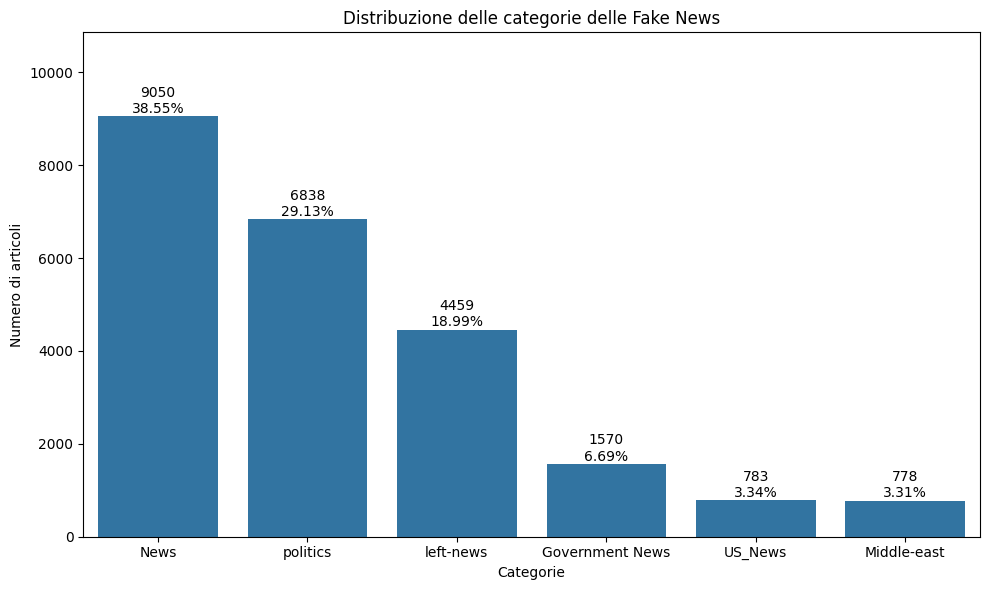

In [31]:
# Calculate the counts of values in the DataFrame
counts = df_fake_cat['subject'].value_counts()

# Calculate the percentage relative to the total
percentages = counts / counts.sum() * 100

# Sort the counts from highest to lowest
counts_sorted = counts.sort_values(ascending=False)

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_fake_cat['subject'], order=counts_sorted.index)
for i, (index, count) in enumerate(counts_sorted.items()):
    plt.text(i, count + 70, f'{count}\n{percentages[index]:,.2f}%', ha='center', color='black')

# Set the range of the y-axis
plt.ylim(0, counts.max() * 1.2)

plt.title('Distribuzione delle categorie delle Fake News')
plt.xlabel('Categorie')
plt.ylabel('Numero di articoli')
 # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

Le FAKE NEWS sono più presenti nella categoria delle notizie generiche (NEWS), questo potrebbe essere dovuto a diversi fattori:

- **Ampia diffusione**: Le fake news possono essere create e diffuse su argomenti di interesse generale per raggiungere un pubblico più ampio. Le notizie generiche potrebbero attrarre più persone, in quanto i creatori di fake news mirano a questa categoria per massimizzare la loro portata.

- **Mancanza di verifica**: Le notizie generiche potrebbero ricevere meno attenzione da parte di coloro che controllano i fatti o la veridicità delle informazioni, permettendo alle fake news di diffondersi più facilmente in questo contesto.

- **Maggiore ambiguità**: Gli argomenti generici potrebbero offrire più spazio per l'interpretazione e l'ambiguità, il che potrebbe rendere più difficile per il pubblico distinguere tra notizie genuine e fake news.

- **Mancanza di approfondimento**: Poiché le notizie generiche non si concentrano su un argomento specifico, potrebbero ricevere meno attenzione e approfondimento da parte dei lettori, che potrebbero quindi essere più inclini a credere a informazioni non verificate o false.


## PER OGNI CATEGORIA, CI SONO ARGOMENTI CHE SONO PIU' SOGGETTI ALLE FAKE NEWS?

In [32]:
# Remove duplicate rows from the DataFrame and create a new DataFrame
df_fake_cat_topic = df_fake.drop_duplicates()

# Concatenate the 'title' and 'text' columns to create a new column 'document'
# This combines the title and text of each entry into a single document
df_fake_cat_topic['document'] = df_fake_cat_topic['title'] + " " + df_fake_cat_topic['text']

# Select only the 'subject' and 'document' columns from the DataFrame
# This discards any other columns from the DataFrame
df_fake_cat_topic = df_fake_cat_topic[['subject', 'document']]

# Randomly sample 10 rows from the DataFrame and display them
# This allows for a quick inspection of a subset of the processed data
df_fake_cat_topic.sample(10)

,subject,document
5792,News,Clinton Gets Trump To Finally Snap: In A Fit ...
5430,News,Slain Officer Had Just Written These Emotiona...
673,News,"Chuck Todd Has No F*cks To Give, Says Jeff Se..."
19228,left-news,BLACK RADIO HOST: DEMOCRATS Have “Owned” Black...
7295,News,4-Year-Old Boy Shot In The Head After ‘Respon...
13177,politics,WATCH: HARRY REID Caught Calling Benghazi Moth...
2215,News,Hannity Claims CIA Framed Trump And Russia Wh...
11950,politics,WATCH SEAN HANNITY Destroy Obama’s Economic Po...
1784,News,Trump Demands Queen Of Britain Pick Him Up In...
11236,politics,SHOCKER: Public School Turns Computer Lab Into...


In [33]:
# Extract unique categories from the 'subject' column of the DataFrame
categories_fake = list(df_fake_cat_topic['subject'].unique())
categories_fake

['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east']

L'analisi LDA (Latent Dirichlet Allocation) è una tecnica di modellazione statistica utilizzata per scoprire temi (argomenti) all'interno di un insieme di documenti. I seguenti parametri configurano un modello LDA e influenzano il modo in cui gli argomenti vengono identificati e interpretati.

1. **num_topics**
   - Questo parametro specifica il numero di argomenti che il modello LDA deve identificare nel corpus di documenti.

2. **alpha**
   - L'alpha è un parametro di iperparametro di Dirichlet che controlla la distribuzione degli argomenti per documento. Un valore più basso di alpha indica che ciascun documento è probabile che contenga pochi argomenti, mentre un valore più alto di alpha implica che i documenti contengano un mix più ampio di argomenti.

3. **eta**
   - L'eta (spesso indicato come beta) è un altro parametro di iperparametro di Dirichlet, ma controlla la distribuzione delle parole per argomento. Un valore più basso di eta indica che ciascun argomento è probabile che contenga poche parole chiave, mentre un valore più alto di eta implica che gli argomenti abbiano un mix più ampio di parole.

4. **iterations**
   - Questo parametro specifica il numero di iterazioni che l'algoritmo deve eseguire durante la fase di addestramento. Un numero maggiore di iterazioni permette al modello di convergere meglio, trovando una distribuzione stabile degli argomenti.

5. **passes**
   - Questo parametro indica il numero di passaggi sull'intero corpus di documenti che l'algoritmo deve eseguire. Maggiori passaggi consentono al modello di rivedere e migliorare continuamente le sue stime degli argomenti in base ai dati del corpus.

Ora eseguiro LDA su una categoria per volta per determinare gli argomenti trattati, andando ad ottimizzare i parametri per ottenere i migliori risultati.


#### ANALISI CATEGORIA "NEWS"

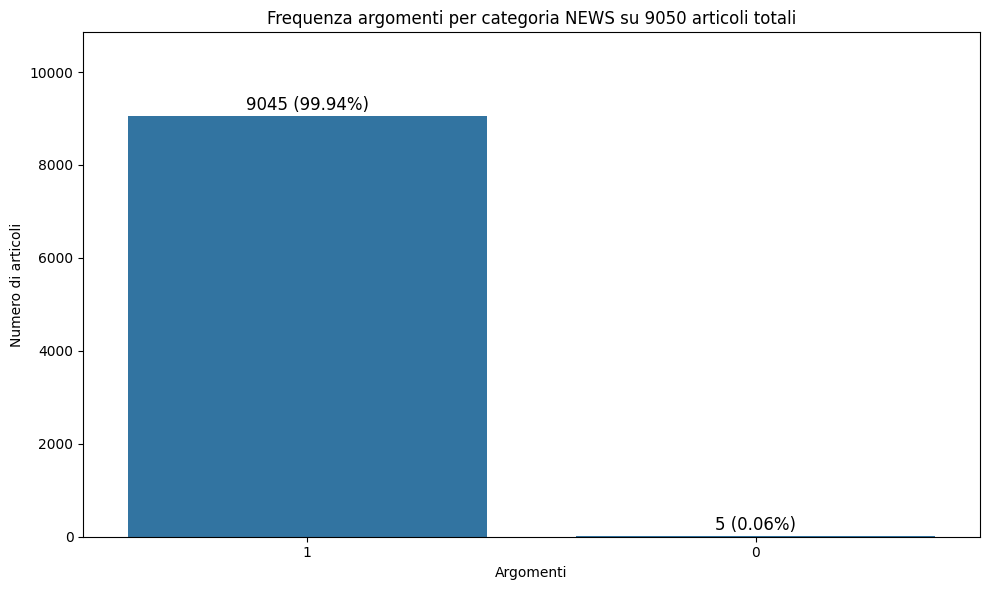

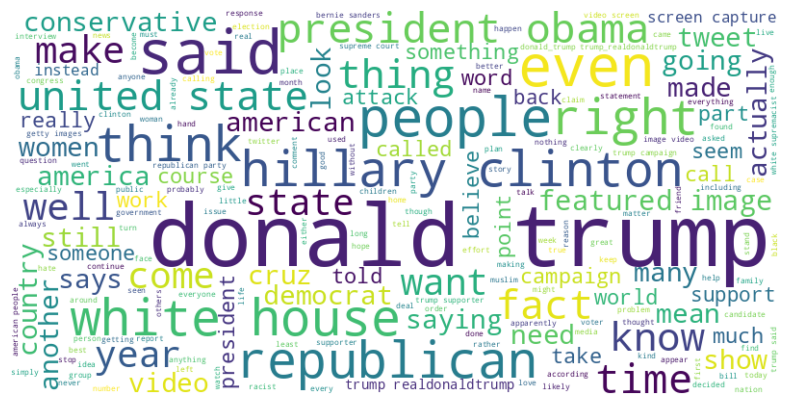

In [52]:
# Define the current category name
current_category_name = 'News'

# Define LDA params
params = {
    'num_topics': 2,
    'alpha': 0.3,
    'eta': 0.4,
    'iterations': 1000,
    'passes': 20
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Gli argomenti forniti sembrano riguardare due figure di spicco in campi diversi. Mentre il primo argomento si concentra sulla scienza e sulla divulgazione scientifica rappresentate da Neil deGrasse Tyson, il secondo argomento riguarda la politica e l'azione governativa associate a Donald Trump come presidente degli Stati Uniti.

#### ANALISI CATEGORIA "POLITICS"

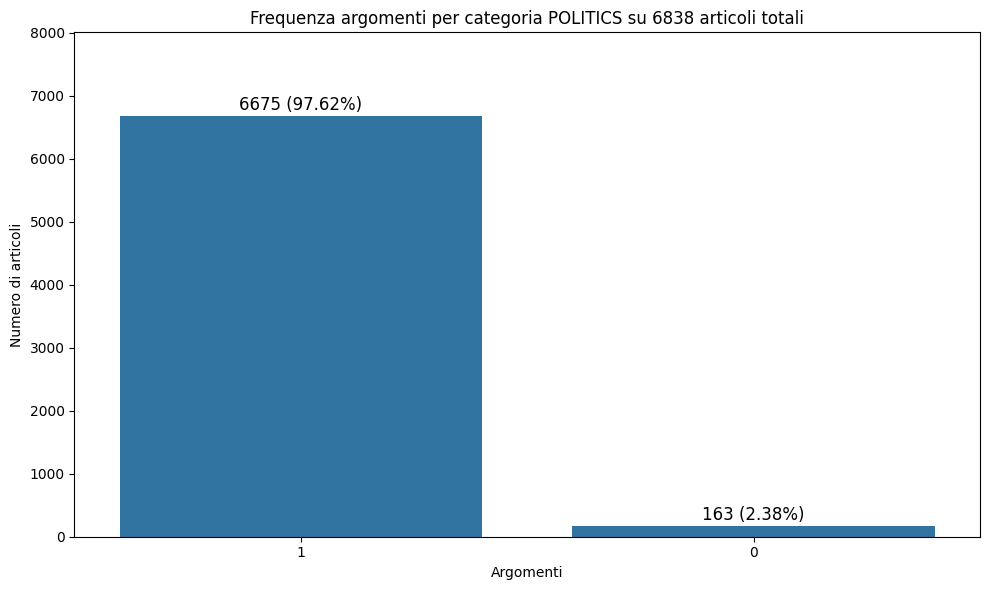

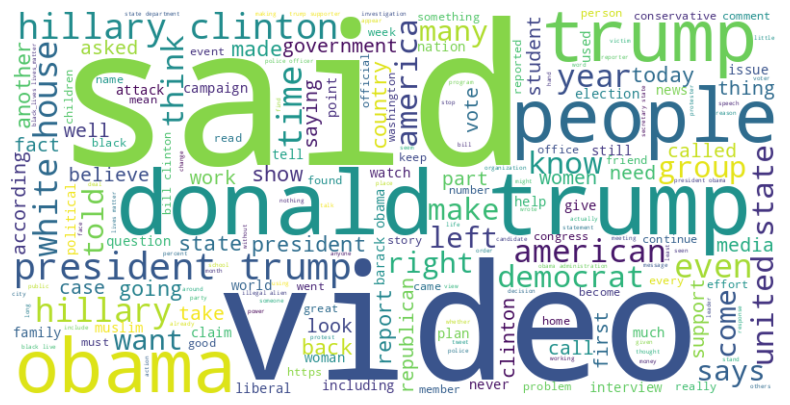

In [50]:
# Define the current category name
current_category_name = 'politics'

# Define LDA params
params = {
    'num_topics': 2,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Gli argomenti trattano principalmente di due figure politiche prominenti: Hillary Clinton e Donald Trump. Nel primo, si discute del server email di Clinton e l'indagine condotta da James Comey sulle sue email. Nel secondo, si fa riferimento principalmente a Trump, con menzioni delle sue dichiarazioni, oltre a figure come Barack Obama e Hillary Clinton. Entrambi gli argomenti ruotano attorno a tematiche politiche di rilievo.

#### ANALISI CATEGORIA "GOVERMENT NEWS"

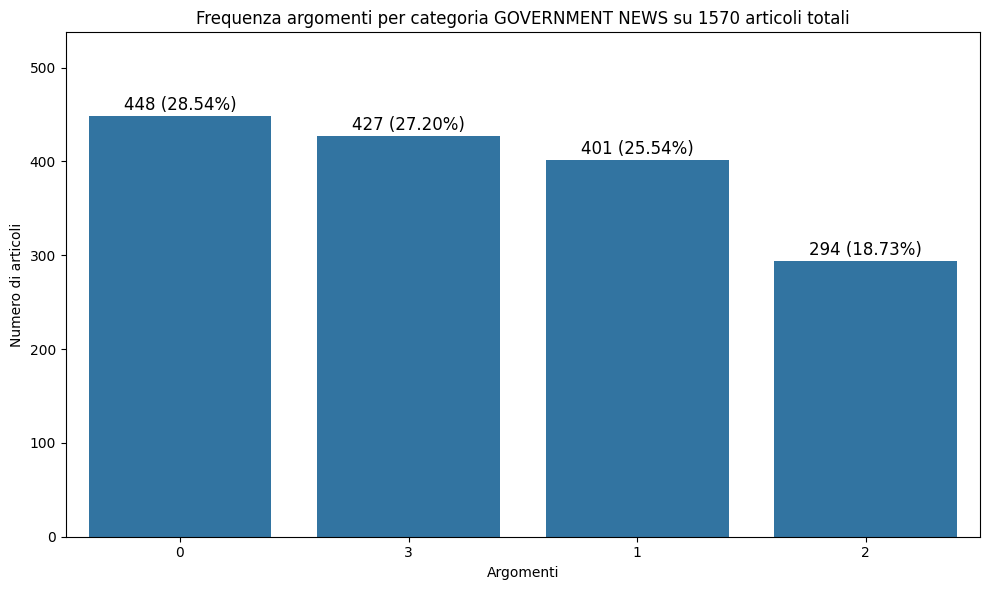

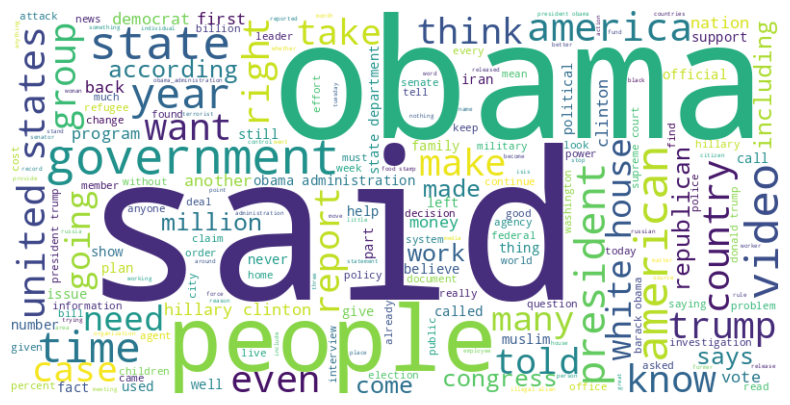

In [48]:
# Define the current category name
current_category_name = 'Government News'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Gli argomenti sembrano ruotare attorno alle figure chiave della politica statunitense come Obama e Trump, con menzioni aggiuntive di Clinton e l'accento su dichiarazioni e azioni politiche. Si tratta di una discussione che comprende le reazioni delle persone e l'effetto sul governo, sottolineando temi come leadership, presidenza e governo statale.

#### ANALISI CATEGORIA "LEFT-NEWS"

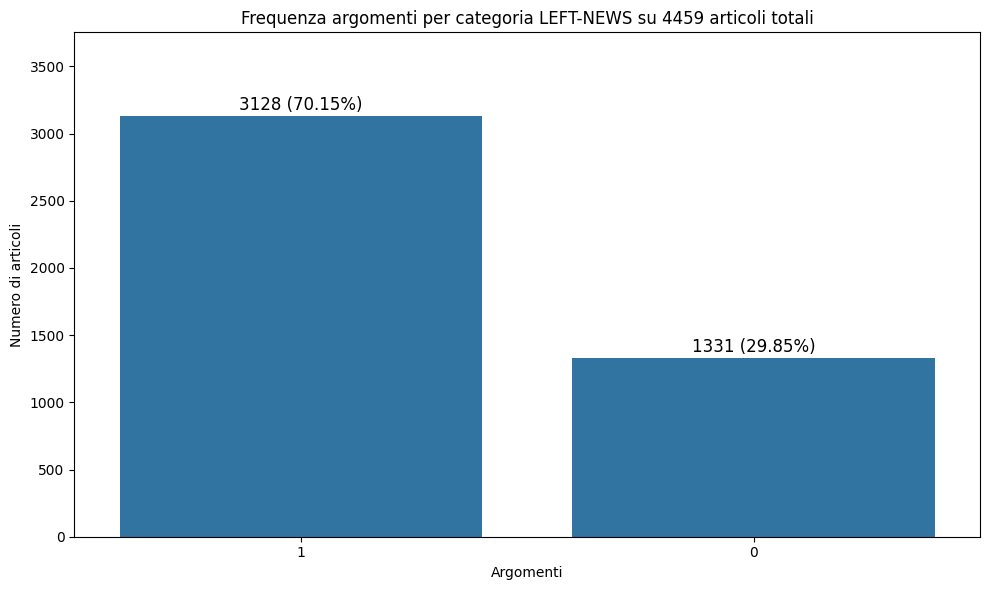

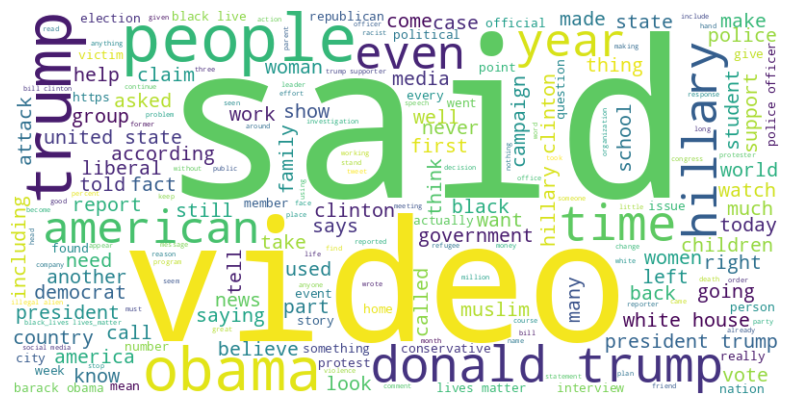

In [47]:
# Define the current category name
current_category_name = 'left-news'

# Define LDA params
params = {
    'num_topics': 2,
    'alpha': 0.2,
    'eta': 0.6,
    'iterations': 1000,
    'passes': 20
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Gli argomenti sembrano concentrarsi su personaggi politici come Hillary Clinton e Donald Trump, insieme ad altre parole chiave come "police" e "Obama". Entrambi potrebbero riguardare dichiarazioni, azioni o opinioni associate a queste figure politiche.







#### ANALISI CATEGORIA "US_NEWS"

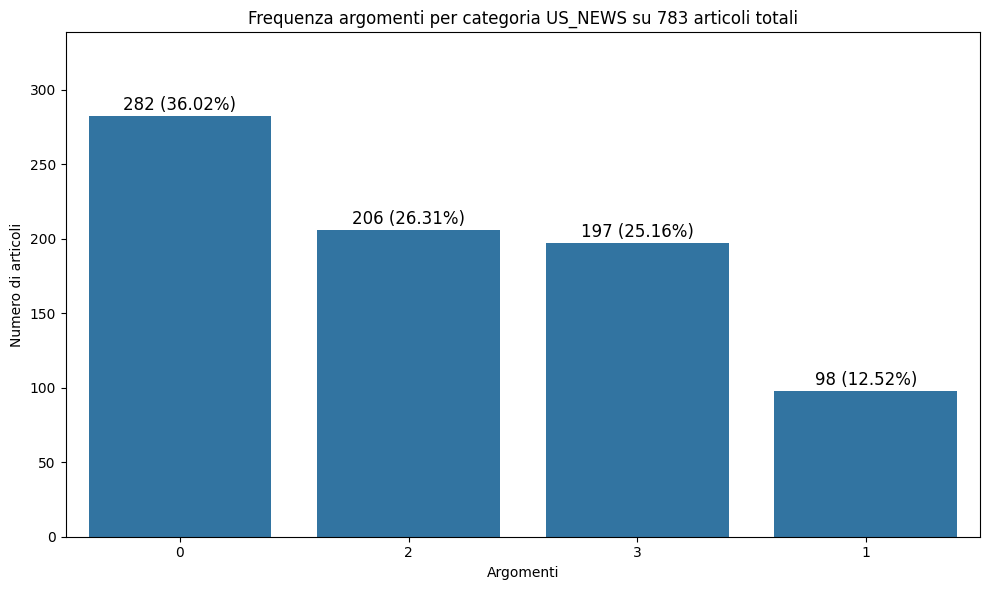

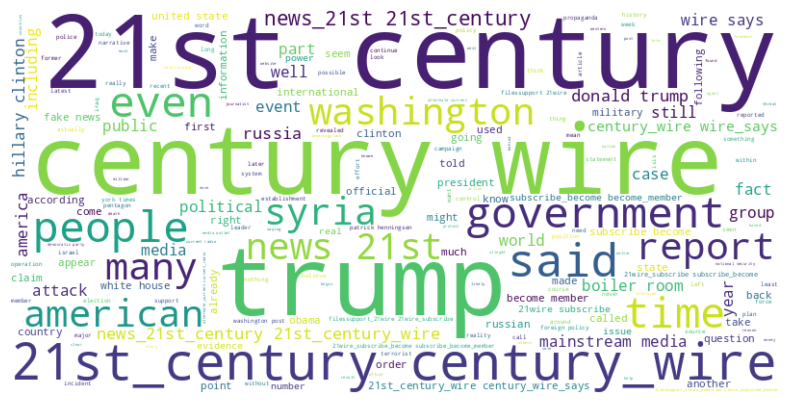

In [44]:
# Define the current category name
current_category_name = 'US_News'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.2,
    'eta': 0.6,
    'iterations': 300,
    'passes': 15
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Sembra che gli argomenti siano focalizzati sulla politica, i media e le notizie, con particolare attenzione a Donald Trump e Hillary Clinton. Le parole chiave come "media", "news" e "Trump" sono comuni in più argomenti, suggerendo che siano temi importanti e ricorrenti nel corpus di testo analizzato. Altri termini come "syria" e "government" indicano la presenza di discussioni su questioni internazionali e governance. Il termine "wire" potrebbe indicare un interesse per le comunicazioni elettroniche o per la sorveglianza, mentre "century" potrebbe suggerire un contesto temporale o storico.

#### ANALISI CATEGORIA "MIDDLE-EAST"

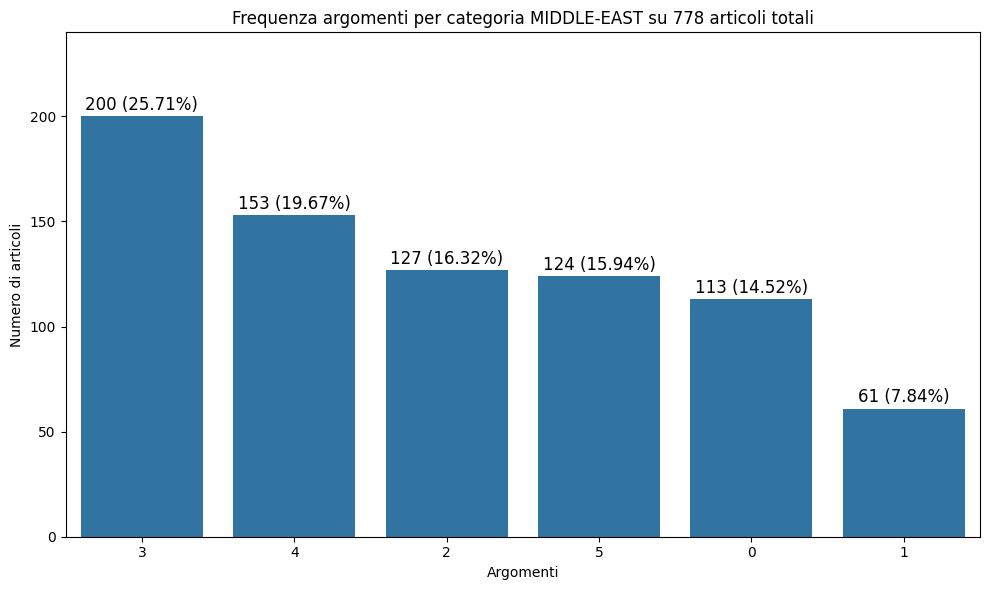

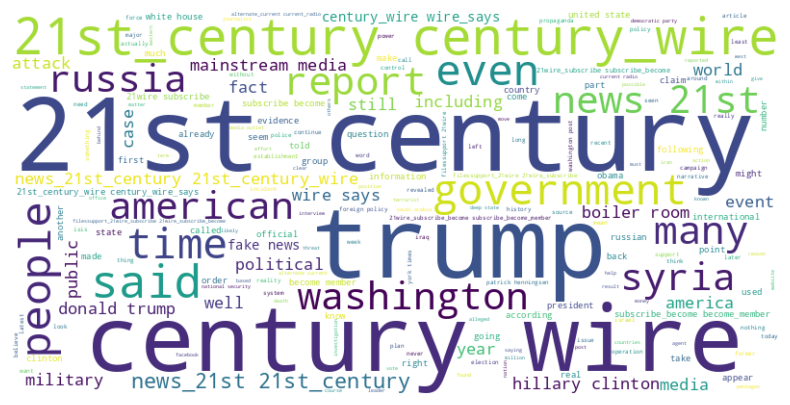

In [42]:
# Define the current category name
current_category_name = 'Middle-east'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.2,
    'eta': 0.6,
    'iterations': 300,
    'passes': 15
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

Gli argomenti individuati sembrano trattare principalmente di politica, media e notizie, con un'enfasi specifica su eventi correlati a Trump, Clinton e altri attori politici rilevanti. Alcuni argomenti sembrano concentrarsi su temi specifici come sparatorie, politica internazionale come la situazione in Siria, e il ruolo dei media nell'informare o influenzare l'opinione pubblica. La presenza di parole chiave come "trump", "media", "news", "political", "shooting", "Syria", "Clinton", suggerisce che questi argomenti ruotino attorno a discussioni politiche e mediatiche rilevanti del momento.

## I TITOLI DELLE FAKE NEWS PRESENTANO DEI PATTERN?

Per determinare se i titoli delle fake news presentano dei pattern, posso utilizzare l'analisi delle parti del discorso (POS) in modo da identificare i ruoli grammaticali di ciascuna parola nei titoli delle fake news. Ad esempio, posso vedere se ci sono schemi comuni nell'uso di determinate categorie di parole (come nomi, verbi, aggettivi).

In [112]:
# Drop duplicate rows based on the 'title' column and store the result in df_fake_title
df_fake_title = df_fake.drop_duplicates()

# Select only the 'title' column from the dataframe
df_fake_title = df_fake_title[['title']]

# Display a random sample of 10 rows from the 'title' column
df_fake_title.sample(10)

,title
9728,TRUMP BLASTS SENATE RINO ON TWITTER…Exposes RE...
1827,WATCH Bill O’Reilly Get INSANELY Vile Over Bl...
5526,President Obama Defends Black Lives Matter Mo...
17512,BIZARRE 2006 FILM Starring Former White House ...
354,"Roy Moore Wants To Be Alabama’s Senator, But ..."
14711,BOOM! Judge Jeanine to Obama: ‘Instead of blam...
19531,OSU DIVERSITY OFFICER Sympathizes With Terrori...
7657,Chelsea Handler Has Hilarious Proposition For...
10023,LOL! CROOKED and IRRELEVANT HILLARY CLINTON GO...
6312,"CNN Attacks Larry Wilmore, Cancels Appearance..."


In [118]:
# Extracting titles of fake news
fake_titles = df_fake_title['title']

# Tokenization and POS tagging
pos_tags = []
for title in fake_titles:
    words = preprocess_text(title)  # Tokenize the title into words
    pos_tags.extend(pos_tag(words))  # Perform POS tagging on the tokenized words

# Counting the most common parts of speech
pos_counts = Counter(tag for word, tag in pos_tags)  # Count occurrences of each POS tag

# Generating HTML code
html_output = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analisi dei titoli di Fake News</title>
</head>
<body>
    <h2>Parti del discorso più comuni</h2>
    <ul>
"""
# Adding parts of speech counts to HTML
for pos, count in pos_counts.items():
    html_output += f"        <li>{pos}: {count}</li>\n"

html_output += """
    </ul>
</body>
</html>
"""

display(HTML(html_output))

Dai questi risultati posso notare che i tag più frequenti sono:

- JJ (aggettivi)
- NN (sostantivi singolari o plurali)
- NNS (sostantivi plurali)
- VBG (verbi gerundi o participio presente)
- VBD (verbi passati)

Oltre a questi, ci sono altri tag POS meno frequenti, ma che comunque possono contribuire all'analisi. Posso anche considerare i seguenti:

- VBZ (verbi terza persona singolare presente)
- VBP (verbi presenti tranne la terza persona singolare)
- RB (avverbi)
- VBN (verbi participio passato)
- VB (verbi base)

Basandomi su queste frequenze, posso ipotizzare alcuni pattern comuni nei titoli delle fake news:

1. **Utilizzo intensivo di aggettivi e sostantivi:** I titoli delle fake news potrebbero contenere un alto numero di aggettivi e sostantivi per suscitare un forte impatto emotivo o attirare l'attenzione del lettore.

2. **Verbi nel presente o passato:** I verbi al presente o al passato potrebbero essere utilizzati per conferire un senso di immediatezza o per dare l'impressione che l'evento descritto sia già accaduto.

3. **Verbi gerundi o participio presente:** Questi verbi potrebbero essere utilizzati per creare un senso di azione in corso o di continuità nel tempo, potenzialmente per dare l'impressione che l'argomento delle fake news sia ancora rilevante o attuale.

4. **Utilizzo di avverbi:** Gli avverbi potrebbero essere utilizzati per enfatizzare o modificare il significato dei verbi o degli aggettivi nel titolo, potenzialmente per manipolare l'interpretazione del lettore.

5. **Rarità di altre parti del discorso:** Alcuni tag POS, come PDT (determinatori predeterminati), EX (espletivi) o UH (intercalari), sono poco frequenti nei dati forniti. Questo potrebbe indicare che le fake news tendono a evitare l'uso di queste parti del discorso nei loro titoli.


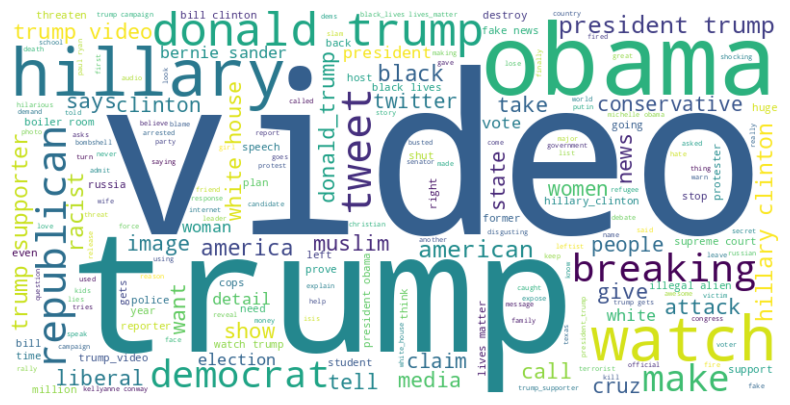

In [117]:
# Extracting words from fake news titles
words_fake = [word.lower() for title in fake_titles for word in preprocess_text(title)]

# Creating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_fake))

# Visualizing the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Vedendo le parole più comuni presenti nei titoli delle fake news posso dire che il tema principale è orientato ad argomenti di politica america, notizie sul presidente in carica o altri presidenti e alle vicissidutini che girano intorno al mondo politco.

## CREAZIONE DEL MODELLO PER IDENTIFICARE LE FAKE NEWS

In [119]:
# Remove duplicate rows from True News DataFrame and assign it to a new DataFrame called df_true_cleaned.
df_true_cleaned = df_true.drop_duplicates()

# Combine 'title' and 'text' columns into a new column named 'document' with a space in between.
df_true_cleaned['document'] = df_true_cleaned['title'] + " " + df_true_cleaned['text']

# Keep only the 'document' column in the DataFrame.
df_true_cleaned = df_true_cleaned[['document']]

# Assign a new column named 'label' with value 0 to indicate that the documents in this DataFrame are true.
df_true_cleaned["label"] = 0

# Return the cleaned DataFrame.
df_true_cleaned

,document,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorit...,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [120]:
# Remove duplicate rows from Fake News DataFrame and assign it to a new DataFrame called df_fake_cleaned.
df_fake_cleaned = df_fake.drop_duplicates()

# Combine 'title' and 'text' columns into a new column named 'document' with a space in between.
df_fake_cleaned['document'] = df_fake_cleaned['title'] + " " + df_fake_cleaned['text']

# Keep only the 'document' column in the DataFrame.
df_fake_cleaned = df_fake_cleaned[['document']]

# Assign a new column named 'label' with value 1 to indicate that the documents in this DataFrame are fake.
df_fake_cleaned["label"] = 1

# Return the cleaned DataFrame.
df_fake_cleaned

,document,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [122]:
# Add a 'label' column to distinguish between true news (1) and false news (0).
# Create a copy of the cleaned true news DataFrame and add a 'label' column with value 1.
df_true_label = df_true_cleaned.copy()
df_true_label['label'] = 0

# Create a copy of the cleaned fake news DataFrame and add a 'label' column with value 0.
df_fake_label = df_fake_cleaned.copy()
df_fake_label['label'] = 1

# Concatenate the true and fake news DataFrames into one DataFrame.
df_full = pd.concat([df_true_label, df_fake_label])

# Sample 15 rows from the merged DataFrame to display.
df_full.sample(15)

,document,label
1962,The Latest Delusion From Devin Nunes Will Mak...,1
16038,"“HARRY, HARRY!” Crowd Yells Military Hero’s Na...",1
19800,BUSTED! LATEST WOMAN TO ACCUSE Trump Of Sexual...,1
5860,U.N. refugee agency hopes resettlement resumes...,0
12156,THE VIEW WOMEN Go Off The Rails: Trump ‘has to...,1
20517,"Pope, in Medellin, recalls 'painful memory' of...",0
22177,CrossTalk: WikiLeaks Vault 7 with Guests Patri...,1
13221,BOOM! WATCH VP CANDIDATE TIM KAINE “Skirt” The...,1
6770,McConnell will not give timeline for Obamacare...,0
16867,WATCH: CNN HOST GETS SCHOOLED By Guest After C...,1


In [125]:
# Initialize a TF-IDF vectorizer with custom preprocessing function
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text_to_string)

# Convert the 'document' column of the DataFrame to a TF-IDF matrix representation
X = tfidf_vectorizer.fit_transform(df_full['document'])

# Define the target variable
y = df_full['label']

# Split the data into training and testing sets
# 80% of the data will be used for training, and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training using Support Vector Machine (SVM) classifier
# We use a linear kernel for the SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

## VALUTAZIONE DEL MODELLO

In [127]:
# Model evaluation
# Predict labels for the test data using the trained SVM model
y_pred = svm_model.predict(X_test)

# Print classification report to evaluate the model's performance
# The classification report includes precision, recall, F1-score, and support for each class.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4290
           1       0.99      0.99      0.99      4648

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



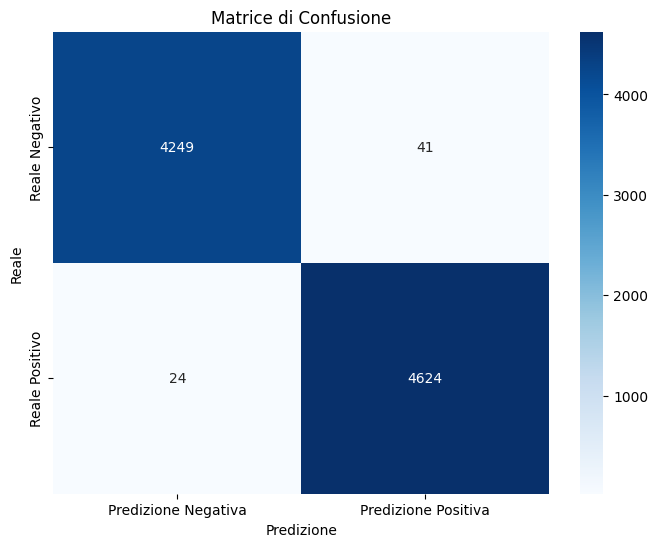

In [132]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predizione Negativa', 'Predizione Positiva'], yticklabels=['Reale Negativo', 'Reale Positivo'])
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()

### Interpretazione delle Metriche

1. **Precision (Precisione)**
   - **Definizione**: La precisione è la proporzione di veri positivi (TP) rispetto al totale delle predizioni positive (TP + FP). Misura la capacità del modello di non classificare come positivi esempi che in realtà sono negativi.
   - **Risultati**:
     - Classe 0: 0.99
     - Classe 1: 0.99

2. **Recall (Richiamo)**
   - **Definizione**: Il richiamo è la proporzione di veri positivi (TP) rispetto al totale dei veri esempi positivi (TP + FN). Misura la capacità del modello di trovare tutti gli esempi positivi.
   - **Risultati**:
     - Classe 0: 0.99
     - Classe 1: 0.99

3. **F1-score**
   - **Definizione**: L'F1-score è la media armonica di precisione e richiamo. È un buon indicatore della performance complessiva del modello, specialmente quando le classi sono sbilanciate.
   - **Risultati**:
     - Classe 0: 0.99
     - Classe 1: 0.99

4. **Supporto (Support)**
   - **Definizione**: Il supporto è il numero di esempi presenti in ciascuna classe del dataset di test.
   - **Risultati**:
     - Classe 0: 4290
     - Classe 1: 4648

5. **Accuracy (Accuratezza)**
   - **Definizione**: L'accuratezza è la proporzione di predizioni corrette (TP + TN) rispetto al totale delle predizioni (TP + TN + FP + FN).
   - **Risultati**: 0.99 su 8938 esempi

6. **Macro Average (Media Macro)**
   - **Definizione**: La media macro è la media semplice delle metriche (precision, recall, F1-score) calcolata per ciascuna classe, senza considerare il numero di esempi per classe.
   - **Risultati**: 0.99 per precision, recall e F1-score

7. **Weighted Average (Media Ponderata)**
   - **Definizione**: La media ponderata tiene conto della proporzione di esempi in ciascuna classe quando calcola la media delle metriche.
   - **Risultati**: 0.99 per precision, recall e F1-score

### Analisi Complessiva

- **Alta Performance**: Tutte le metriche mostrano un valore molto alto (0.99), indicando che il modello ha una performance eccellente sia in termini di precisione che di richiamo.
- **Equilibrio tra Classi**: Le metriche sono ugualmente elevate per entrambe le classi (0 e 1), suggerendo che il modello è ben bilanciato e non favorisce una classe rispetto all'altra.
- **Conferma dell'Accuratezza**: L'accuratezza complessiva è molto alta (0.99), supportata dalle elevate precisioni, richiami e F1-score.

Questi risultati indicano che il modello di classificazione è altamente efficace nel distinguere tra le due classi del dataset.

## Esportazione del Modello

In [128]:
# Serialize and save the svm_model object using pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

## ESEMPIO DI UTILIZZO DEL MODELLO SALVATO

```python
# Import pickle module
import pickle

# Load the model
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Provide input data
input_data = ...

# Make predictions
predicted_labels = svm_model.predict(input_data)

# Use the predictions
print(predicted_labels)
```